# Exploratory Data Analysis for Jane Street Real-Time Market Data Forecasting

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv, pd.read_parquet )
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter

In [2]:
PATH="/kaggle/input/jane-street-real-time-market-data-forecasting"
train=pl.read_parquet(PATH+"/train.parquet/partition_id=0/part-0.parquet")
train.shape

(1944210, 92)

In [3]:
train.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,…,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,…,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,…,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,…,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,null,0.646086,null,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,null,…,1.253902,null,null,0.476195,null,-0.771732,2.843421,null,1.379815,0.411827,-1.36224,null,null,null,null,null,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,null,null,3.678076,2.793581,2.61825,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.0,-3.57282,-1.089123,-5.0


## Missing Values 

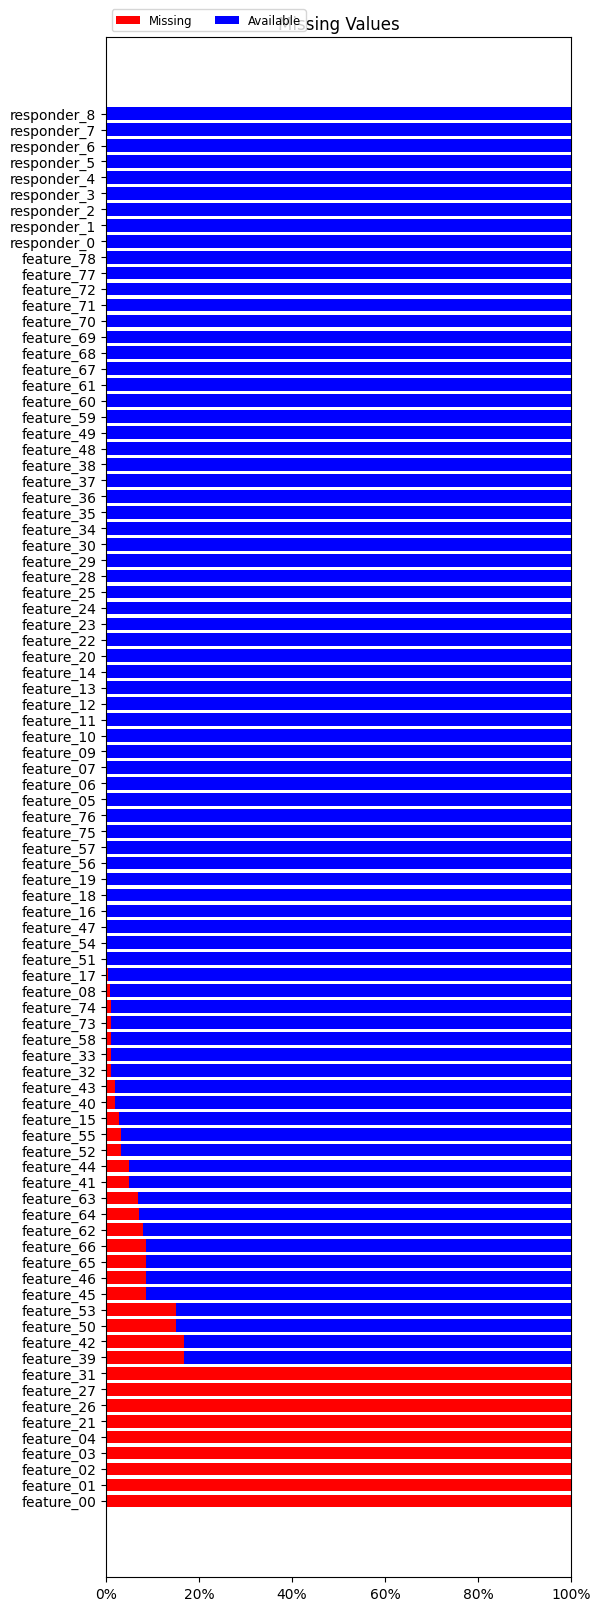

In [5]:
missing_values=train.drop(["date_id","time_id", "symbol_id", "weight"])
missing_values=missing_values.null_count().transpose(
    include_header=True, header_name='feature',column_names=['number_of_missing_values'])
missing_values=missing_values.sort('number_of_missing_values', descending=True).with_columns(
    (pl.col('number_of_missing_values') / len(train)).alias('null_ratio'))

category_names=["Available", "Missing"]
labels=list(missing_values.get_column('feature'))
plt.figure(figsize=(6, 20))
plt.barh(np.arange(len(missing_values)), 
         missing_values.get_column('null_ratio'), 
         color='red', 
         label='Missing')
plt.barh(np.arange(len(missing_values)), 
        1 - missing_values.get_column('null_ratio'),
        left=missing_values.get_column('null_ratio'),
        color="blue",
        label='Available')
plt.yticks(np.arange(len(missing_values)), missing_values.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

plt.xlim(0, 1)
plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
plt.title('Missing Values')
plt.show()
#plt.barh()
#plt.yticks(np.arange(len(missing_values)), missing_values.get_column('feature'))


In [6]:
info=train.select(pl.col(f"feature_{i:02d}") for i in range(79) if i not in {9,10,11}) #No need for cathegorical features
means=info.mean()
stds=info.std()
maxs=info.max()
mins=info.min()
info=pl.concat([means,stds,maxs,mins]).insert_column(0, column=pl.Series(["Mean","Std","Max","Min"]).alias("Statistic"))
info[[s.name for s in info if not (s.null_count() == info.height)]] #Drop columns that have nulls

Statistic,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""Mean""",-0.044632,-0.006456,-0.019842,0.059797,0.053623,0.03939,0.058634,0.331464,0.255926,0.32587,0.116747,0.034538,0.325885,0.429067,0.399052,-0.999268,0.196233,0.163988,-0.019372,0.381216,-0.140876,-0.008343,-0.145856,-0.143522,0.00119,0.035701,0.068051,-0.299491,-0.016442,-0.17055,0.368643,0.087647,0.245554,-0.312995,0.338614,-0.0523,-0.005337,-0.021053,0.051325,0.044491,0.118185,-0.092012,0.006591,-0.104968,-0.076846,-0.037126,-0.033732,-0.006372,-0.017632,-0.034067,0.649949,0.556831,0.580783,0.300181,0.231899,0.063448,0.037422,0.061478,0.04048,0.029071,0.048575,-0.118527,-0.120112,-0.083468,-0.084515,-0.096821,-0.098051
"""Std""",0.947958,0.935119,0.967365,0.92284,1.221367,1.301022,1.230007,1.105641,1.265235,1.173493,1.002713,1.038083,1.026575,0.943643,0.881062,0.734232,0.994776,0.937258,0.829064,1.08911,0.926221,1.244159,0.832473,0.841303,1.188735,1.014692,1.050283,1.451292,1.582897,1.544337,1.431318,1.578296,1.524057,1.293884,1.283443,1.719946,1.732708,1.774442,0.997495,1.222116,1.045308,0.993687,1.225616,1.055472,1.024146,1.004834,0.979773,0.979413,0.98268,1.109674,2.686165,2.578012,2.651716,0.912934,0.908562,1.232994,1.317462,1.253779,1.243743,1.316291,1.270607,0.642401,0.6352,0.759618,0.754082,0.649495,0.639899
"""Max""",15.319997,24.158113,28.097809,13.068775,60.562263,134.205566,82.134956,86.971992,220.132477,134.500641,5.266371,5.635514,4.54154,3.755303,2.896742,3.376201,3.465797,2.493492,4.861078,9.321818,4.302386,4.228292,5.069967,5.337609,5.172071,19.543442,17.904284,5.585663,5.473479,5.24801,5.148483,5.151497,4.940858,5.223101,4.685759,62.63773,316.327209,147.358536,5.939867,5.809254,5.672063,5.086051,4.036324,4.242128,4.164509,4.113091,58.441505,186.287704,120.785431,5.267138,131.933029,162.320709,149.883102,5.063167,4.476054,53.487972,207.99649,72.41835,63.75872,168.990189,112.492989,34.819763,36.516098,42.018932,41.826225,46.722252,43.70195
"""Min""",-11.76608,-25.143543,-20.321791,-6.224619,-1.913078,-0.892107,-1.318024,-1.35983,-1.760566,-1.673085,-6.000734,-4.55074,-3.294369,-1.971631,-1.752133,-3.110884,-1.650518,-3.150075,-1.023257,-1.059913,-3.743401,-4.335631,-3.763025,-3.713827,-5.161081,-12.10517,-14.871572,-5.605368,-5.280773,-5.0186,-5.358385,-5.15849,-5.854246,-5.539638,-5.315288,-49.94656,-311.418213,-97.675621,-5.315659,-4.363397,-4.15804,-5.353856,-5.606056,-5.698468,-4.26841,-4.189552,-33.358139,-169.922882,-62.636726,-5.049103,-0.932498,-0.821984,-0.911218,-3.682407,-3.53722,-1.634,-0.69844,-1.281004,-1.741313,-0.802825,-1.379583,-3.079401,-3.232666,-4.003407,-3.784688,-3.693742,-3.393299


## Feature Correlation

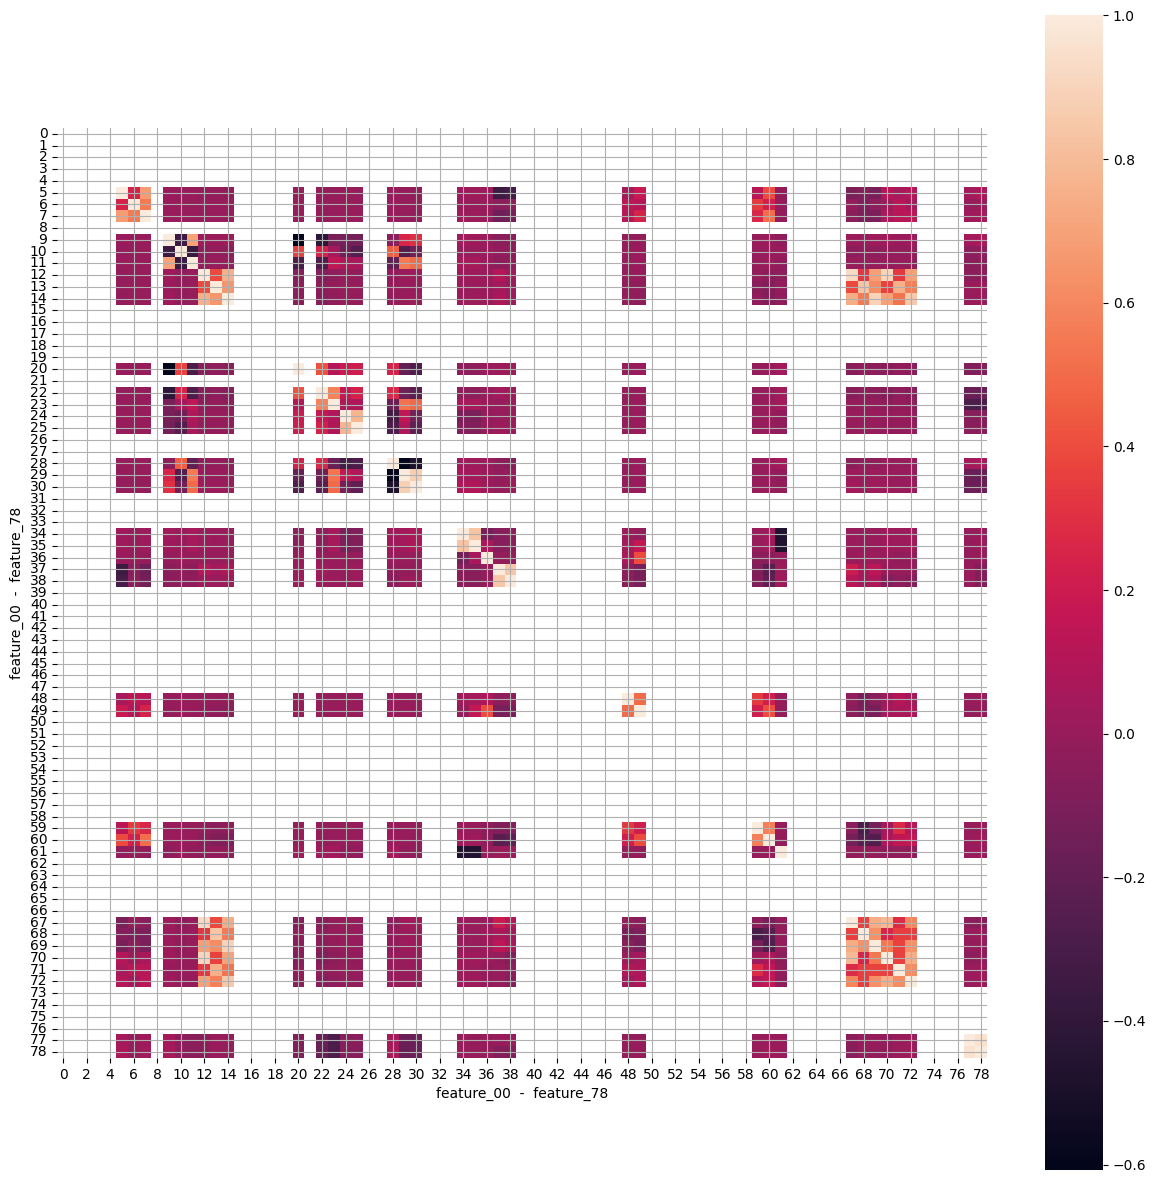

In [7]:
plt.figure(figsize=(15, 15))
sns.heatmap(train[[ f"feature_{target:02d}" for target in range(79)]].corr(), square=True)
plt.xlabel("feature_00  -  feature_78")
plt.ylabel("feature_00  -  feature_78")
plt.grid()
plt.show()

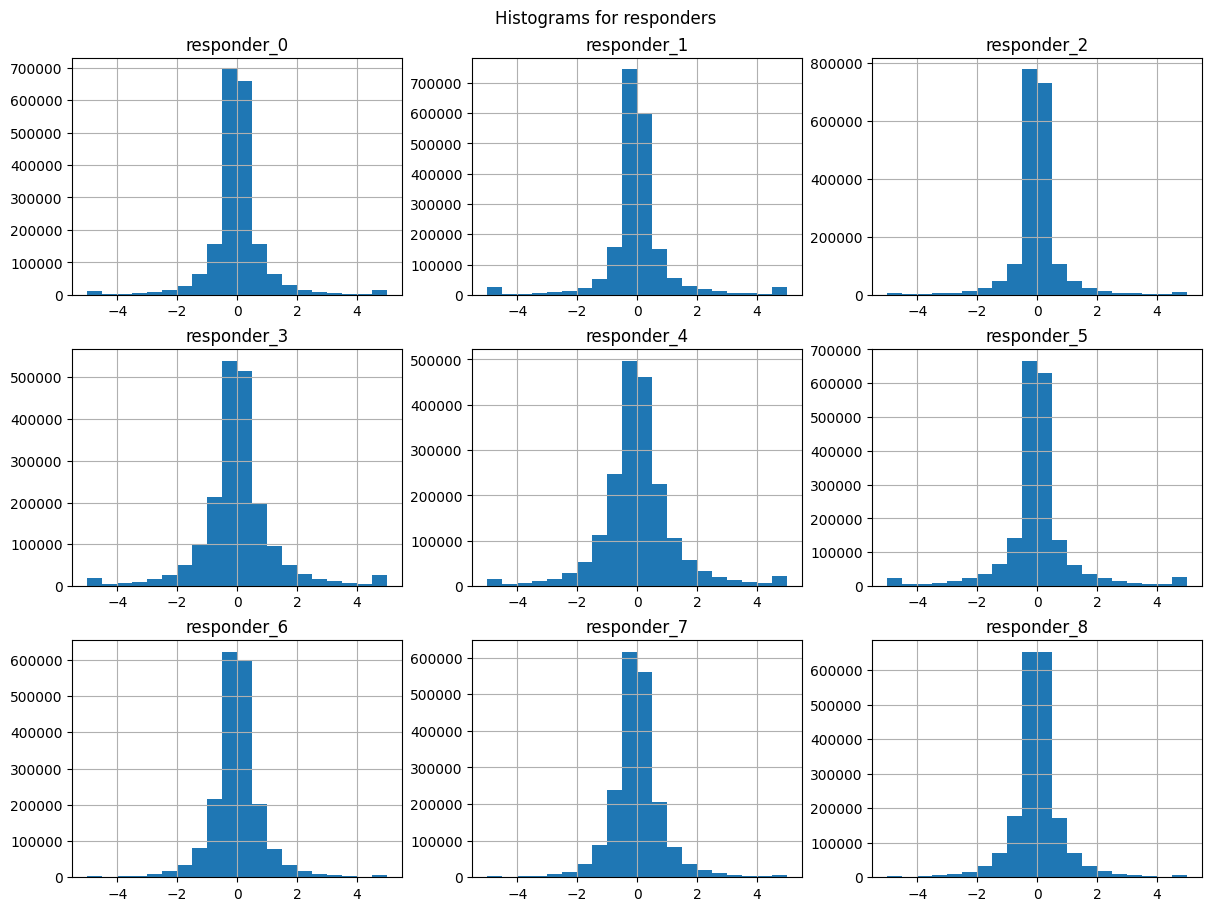

In [8]:
fig, axs = plt.subplots(3, 3,figsize=(12, 9), layout="constrained")
i=0
for row in axs:
    for col in row:
        column = f"responder_{i}"
        col.hist(train[column], bins=20)
        col.title.set_text(f"responder_{i}")
        col.grid()
        i+=1
plt.suptitle("Histograms for responders")
plt.show()

In [9]:
info=train.select(pl.col(f"responder_{i}") for i in range(9))
means=info.mean()
stds=info.std()
maxs=info.max()
mins=info.min()
pl.concat([means,stds,maxs,mins]).insert_column(0, column=pl.Series(["Mean","Std","Max","Min"]).alias("Statistic"))

Statistic,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""Mean""",0.008425,0.010765,0.002413,0.011391,0.021855,0.003327,0.001488,-0.000482,0.001078
"""Std""",0.955878,1.141793,0.844203,1.276044,1.266448,1.225165,0.870577,0.891815,0.873732
"""Max""",5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
"""Min""",-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0


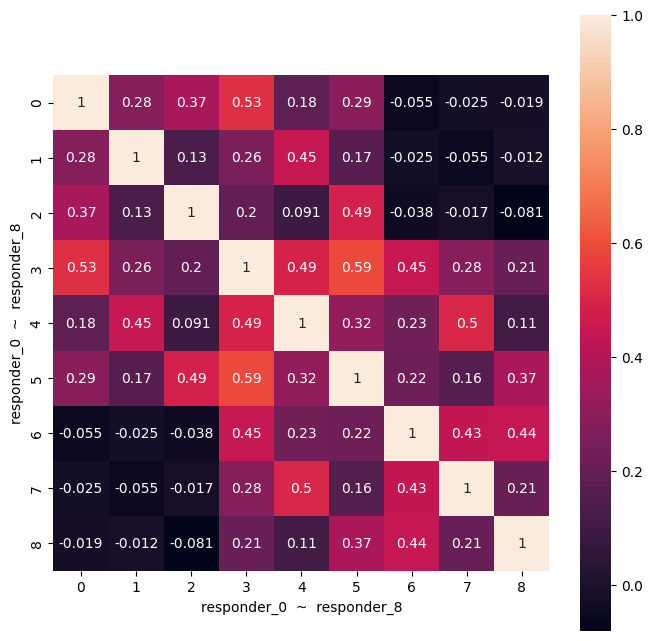

In [10]:
plt.figure(figsize=(8, 8))
sns.heatmap(train[[ f"responder_{target}" for target in range(9)]].corr(),  annot=True, square=True)
plt.xlabel("responder_0  ~  responder_8")
plt.ylabel("responder_0  ~  responder_8")
plt.show()